In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xlrd
import datetime
from datetime import timedelta

In [2]:
data = pd.read_excel('Data.xlsx')
#data.head()

In [3]:
entries = "Total rows: {0}".format(len(data))
print (entries)

Total rows: 8760


In [4]:
data.dtypes

No                                     int64
Date                          datetime64[ns]
Hour                                   int64
Load                                 float64
Wind Speed (m/s)                     float64
PV Production (kW)                   float64
Total Wind Production (kW)           float64
dtype: object

In [5]:
data.describe()

,No,Hour,Load,Wind Speed (m/s),PV Production (kW),Total Wind Production (kW)
count,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000
mean,4380.500000,11.500000,1206.993747,5.955160,465.103723,509.818825
std,2528.938512,6.922582,273.366649,0.895772,772.804194,298.686848
min,1.000000,0.000000,829.756000,3.266542,0.000000,11.059908
25%,2190.750000,5.750000,1005.100000,5.271204,0.000000,298.617511
50%,4380.500000,11.500000,1142.628000,5.942433,12.236907,442.396313
75%,6570.250000,17.250000,1317.428000,6.665088,617.963779,713.364055
max,8760.000000,23.000000,2643.228000,8.646830,3505.873715,1609.216590


In [6]:
data.dtypes

No                                     int64
Date                          datetime64[ns]
Hour                                   int64
Load                                 float64
Wind Speed (m/s)                     float64
PV Production (kW)                   float64
Total Wind Production (kW)           float64
dtype: object

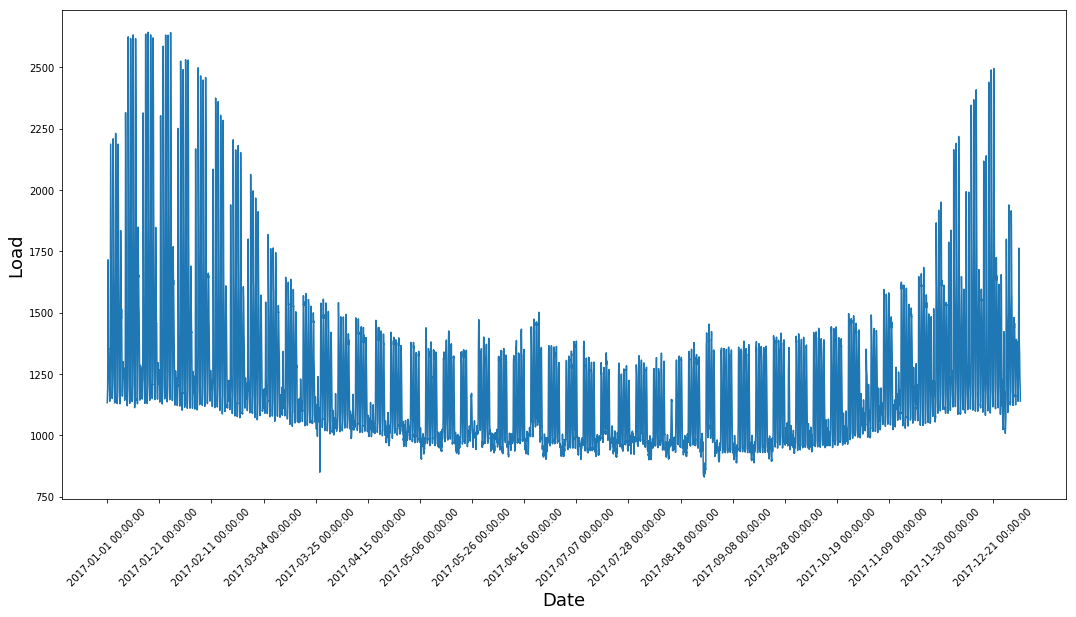

In [7]:
plt.figure(figsize = (18,9))
plt.plot(range(data.shape[0]),(data['Load']))
plt.xticks(range(0,data.shape[0],500),data['Date'].loc[::500],rotation=45)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Load',fontsize=18)
plt.show()

In [ ]:
data = pd.read_excel('Data.xlsx')
from datetime import date

data["DAY_TYPE"] = data.Date.apply(lambda x: 1 if x.dayofweek > 5 else 0  )
data["Day_Name"] = data['Date'].dt.weekday_name

from pandas.tseries.holiday import Holiday, AbstractHolidayCalendar
class BelgianHolidaysCalendar(AbstractHolidayCalendar):
    rules = [Holiday('NY', month=1, day=1),
             Holiday('Easter', month=4, day=17),
         Holiday('Labour day', month=5, day=1),
         Holiday('Ascension day', month=5, day=25),
         Holiday('White Monday day', month=6, day=5),
             Holiday('Belgian National day', month=7, day=21),
             Holiday('Assumption day', month=8, day=15),
             Holiday('All Saints day', month=11, day=1),
             Holiday('Armistice day', month=11, day=11),
             Holiday('Xmas day', month=12, day=25)
   ]
    
cal = BelgianHolidaysCalendar()
holidays = cal.holidays(start = data.Date.min(), end = data.Date.max())
data["IS_HOLIDAY"] = data.Date.isin(holidays)
data.IS_HOLIDAY = data.IS_HOLIDAY.astype("int")
data.head()

In [ ]:
#data = data.set_index(['dts'], drop=True)
#data1 = data[['DAY_TYPE', 'IS_HOLIDAY', 'Load']]
#data = data.set_index(['Date'], drop=True)

data = data[['Date','Load','DAY_TYPE', 'IS_HOLIDAY']]
data.head()

In [ ]:
import numpy
import matplotlib.pyplot as plt
import pandas
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, RNN, GRU, SimpleRNN
from keras.layers import Dropout  
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [ ]:
minVal = min(data['Load']);
maxVal = max(data['Load']);
v = data['Load'].tolist()
norm=[]
for x in v:
    x= (x- minVal) / ( maxVal - minVal )
    norm.append(x)
data['Load'] = norm
data.head()

In [ ]:
data.tail()

In [ ]:
for obs in range(1,49):
    data["T_" + str(obs)] = data.Load.shift(obs)
data.fillna(0.00,inplace=True)


In [ ]:
data.head()

In [ ]:
training_data = data[data.Date < pd.to_datetime("10/01/2017")]

val_mask = (data.Date >= pd.to_datetime("10/01/2017")) & (data.Date < pd.to_datetime("11/01/2017"))
val_data = data.loc[val_mask]

test_data = data[data.Date >= pd.to_datetime("11/01/2017")]

training_data = training_data.drop(["Date"],axis=1)
val_data = val_data.drop(["Date"],axis=1)
test_data = test_data.drop(["Date"],axis=1)
training_data.tail(3)

In [ ]:
training_data.head(2)


In [ ]:
x_train = training_data.drop(["Load"],axis=1)
y_train = training_data.Load

x_val = val_data.drop(["Load"],axis=1)
y_val = val_data.Load

x_test = test_data.drop(["Load"],axis=1)
y_test = test_data.Load

In [ ]:
#x_train

In [ ]:
model_k = Sequential()
model_k.add(LSTM(14, return_sequences=False, input_shape=(1,50)))
model_k.add(Dropout(0.1))  

#model_k.add(LSTM(6, return_sequences=False))  
#model_k.add(Dropout(0.1))  

model_k.add(Dense(1))
model_k.compile(loss='mean_squared_error', optimizer='adam')

In [ ]:
x_train_reshaped = x_train.values.reshape((x_train.shape[0], 1, x_train.shape[1]))
x_val_reshaped = x_val.values.reshape((x_val.shape[0], 1, x_val.shape[1]))
x_test_reshaped = x_test.values.reshape((x_test.shape[0], 1, x_test.shape[1]))

In [ ]:
history = model_k.fit(x_train_reshaped, y_train, validation_data=(x_val_reshaped, y_val), epochs=20, batch_size=64, verbose=2)

In [ ]:
plt.plot(history.history['loss'], label='train', color = 'r')
plt.plot(history.history['val_loss'], label='val')
plt.ylabel('Loss',fontsize=12)
plt.xlabel('Epoch',fontsize=12)
plt.legend()

In [ ]:
res = model_k.predict(x_test_reshaped)

In [ ]:
test_data["DL_PRED"] = res

In [ ]:
from sklearn.metrics import mean_squared_error
from math import sqrt

testLoadList = test_data.Load.values.tolist()
testPredLoadList = test_data.DL_PRED.values.tolist()

rmse = [0]*len(testLoadList)
for i in range (0,len(testLoadList)):
    rmse[i] = (testLoadList[i]-testPredLoadList[i])/testLoadList[i]
test_data['rmse']=rmse

from sklearn import datasets
from sklearn.model_selection import cross_val_predict
from sklearn import linear_model
import matplotlib.pyplot as plt

lr = linear_model.LinearRegression()
x = test_data['Load']
y = test_data["DL_PRED"]

fig,ax = plt.subplots()
ax.scatter(y, x)
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'r', lw=2)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
fig.show()


In [ ]:
from scipy import interpolate

plt.figure(figsize=(20,10))
#test_data_withDates=data[(data['Date']>=datetime.date(2017,11,1))]
#test_data_xaxis = test_data_withDates['Date']
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off

plt.plot(test_data['DL_PRED'],'r', label='Prediction')
plt.plot(test_data['Load'],'g')

plt.ylabel('Energy (Normalized)',fontsize=12)
plt.xlabel('Date: November & December 2017',fontsize=12)
plt.legend()

In [ ]:
from numpy import sqrt
sqrt(mean_squared_error(test_data.Load,test_data.DL_PRED))

In [ ]:
model_g = Sequential()
model_g.add(GRU(14, return_sequences=False, input_shape=(1,50)))
model_g.add(Dropout(0.1))  

#model_k.add(LSTM(6, return_sequences=False))  
#model_k.add(Dropout(0.1))  

model_g.add(Dense(1))
model_g.compile(loss='mean_squared_error', optimizer='adam')

In [ ]:
history_gru = model_g.fit(x_train_reshaped, y_train, validation_data=(x_val_reshaped, y_val), epochs=20, batch_size=64, verbose=2)

In [ ]:
plt.plot(history_gru.history['loss'], label='train', color = 'r')
plt.plot(history_gru.history['val_loss'], label='val')
plt.ylabel('Loss',fontsize=12)
plt.xlabel('Epoch',fontsize=12)
plt.legend()

In [ ]:
res_gru = model_g.predict(x_test_reshaped)

In [ ]:
test_data["DL_PRED_GRU"] = res_gru
x = test_data['Load']
y = test_data["DL_PRED_GRU"]

fig,ax = plt.subplots()
ax.scatter(y, x)
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'r', lw=2)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
fig.show()

In [ ]:
plt.figure(figsize=(20,10))
#test_data_withDates=data[(data['Date']>=datetime.date(2017,11,1))]
#test_data_xaxis = test_data_withDates['Date']
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off

plt.plot(test_data['DL_PRED_GRU'],'m')
plt.plot(test_data['Load'],'g')
plt.legend()

In [ ]:
sqrt(mean_squared_error(test_data.Load,test_data.DL_PRED_GRU))

In [ ]:
( maxVal - minVal ) * 0.028088220676590434 + minVal


In [ ]:
model_rnn = Sequential()
model_rnn.add(SimpleRNN(14, return_sequences=False, input_shape=(1,50)))
model_rnn.add(Dropout(0.1))  

#model_k.add(LSTM(6, return_sequences=False))  
#model_k.add(Dropout(0.1))  

model_rnn.add(Dense(1))
model_rnn.compile(loss='mean_squared_error', optimizer='adam')

In [ ]:
history_rnn = model_rnn.fit(x_train_reshaped, y_train, validation_data=(x_val_reshaped, y_val), epochs=20, batch_size=64, verbose=2)

In [ ]:
plt.plot(history_rnn.history['loss'], label='train', color = 'r')
plt.plot(history_rnn.history['val_loss'], label='val')
plt.ylabel('Loss',fontsize=12)
plt.xlabel('Epoch',fontsize=12)
plt.legend()

In [ ]:
res_rnn = model_rnn.predict(x_test_reshaped)

In [ ]:
test_data["DL_PRED_RNN"] = res_rnn
x = test_data['Load']
y = test_data["DL_PRED_RNN"]

fig,ax = plt.subplots()
ax.scatter(y, x)
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'r', lw=2)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
fig.show()

In [ ]:
sqrt(mean_squared_error(test_data.Load,test_data.DL_PRED_RNN))

In [ ]:
plt.plot(history_rnn.history['loss'], label='trainRNN', color = '#FF0000')
plt.plot(history_rnn.history['val_loss'], label='valRNN', color = '#FF0000')
plt.plot(history.history['loss'], label='trainLSTM', color = '#09CF00')
plt.plot(history.history['val_loss'], label='valLSTM', color = '#09CF00')
plt.plot(history_gru.history['loss'], label='trainGRU', color = '#0064FF')
plt.plot(history_gru.history['val_loss'], label='valGRU', color = '#0064FF')
plt.ylabel('Loss',fontsize=12)
plt.xlabel('Epoch',fontsize=12)
plt.legend()

In [ ]:
plt.figure(figsize=(20,10))
#test_data_withDates=data[(data['Date']>=datetime.date(2017,11,1))]
#test_data_xaxis = test_data_withDates['Date']
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off

plt.plot(test_data['DL_PRED_GRU'],'m')
plt.plot(test_data['PV'],'g')
plt.legend()

In [ ]:
test_data['Load'].mean()